# Projet 7 : Implémentez un modèle de scoring

<hr style="border:2px solid black"> </hr>

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite **mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse ou non son crédit**, **puis classifie la demande en crédit accordé ou refusé**. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

**Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.**

<hr style="border:0.1px solid black"> </hr>

## Sommaire

- Mise en place de l'environnement virtuel
- Ouverture des données
- Constitution d'une base de données unique
 - App Train & Test
 - Bureau & bureau_balance
 - Credit_balance
 - Installments_payments
  - Cash_balance
 - Previous_application
- Sélection de features

<hr style="border:0.1px solid black"> </hr>

## Mise en place de l'environnement virtuel

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
from sklearn.preprocessing import LabelEncoder

<hr style="border:0.1px solid black"> </hr>

## Ouverture des données

Les données sont fournies par **Home Credit**, **un service dédié à la fourniture de lignes de crédit (prêts) à la population non bancarisée** : **prédire si un client remboursera ou non un prêt ou s'il aura des difficultés est un besoin commercial critique**

**7 fichiers** contiennent les données fournies par l'entreprise (**ces fichiers se "relient" entre eux par différentes features clés**, de type ID) :
- application_train/ application_test
- bureau
- bureau_balance
- credit_card_balance
- installments_payments
- POS_CASH_balance
- previous_application

**1 fichier ("HomeCredit_columns_description") contient les descriptions de chacune de nos features** ; ce fichier peut nous permettre de comprendre l'objectif de chacun des fichiers fournis

Il s'agit donc d'abord de **lire chacun de ces fichiers sous la forme de dataframes individuels** afin de faciliter la lecture et de mieux comprendre ce que chacun d'entre eux contient ; on écarte ici le document **"sample_submission"**

In [4]:
fichiers = ['application_test',
            'application_train',
            'bureau',
            'bureau_balance',
            'credit_card_balance',
            'installments_payments',
            'POS_CASH_balance',
            'previous_application']

In [5]:
dataframe = []

In [6]:
for i in range(len(fichiers)):
    rajout = pd.read_csv('C:\\Users\\pauline_castoriadis\\OneDrive - eVoyageurs\\Docs Pauline\\Formation\\Projet 7\\data\\'
                          + fichiers[i] + ".csv",sep = ',')
    dataframe.append(rajout)

In [7]:
description = pd.read_excel('C:\\Users\\pauline_castoriadis\\OneDrive - eVoyageurs\\Docs Pauline\\Formation\\Projet 7\\data\\description.xlsx')

Ces **fichiers se connectent entre eux à l'aide de certaines variables**, l'objectif est de **créer une base de données unique** pour pouvoir réaliser notre prédiction

<hr style="border:0.1px solid black"> </hr>

## Constitution d'une base de données unique

### Bases de données app train & test

#### Principales informations

*Introduction*

In [8]:
app_test = dataframe[0]
app_train = dataframe[1]

Selon les informations fournies par l'entreprise, les deux bases "app_train" et "app_test" sont nos deux bases de données principales, **avec des données pour toutes les demandes de crédit confondues** (chaque prêt a sa propre ligne et est identifié par la caractéristique "SK_ID_CURR")

In [9]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [10]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

On constate que **la base app_train contient 16 variables catégorielles** ; on peut rapidement regarder **le nombre d'entrées uniques** dans chacune de ces colonnes catégorielles

In [11]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques (entre 2 et 6) ; néanmoins, **on devra traiter ces variables catégorielles** (par exemple, certaines telles que ORGANIZATION_TYPE et OCCUPATION_TYPE prennent potentiellement un grand nombre de catégories)

In [12]:
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [13]:
app_test.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

On constate que **la répartition des natures de colonnes entre la base train et la base test est également cohérente**

*Feature TARGET*

In [14]:
app_train.columns.difference(app_test.columns)

Index(['TARGET'], dtype='object')

Les fichiers **"application_train" et "application_test" sont les deux fichiers principaux** fournis par l'entreprise ; chacun contient exactement les mêmes features (au nombre de 121 pour l'instant), **il n'y a que la colonne "TARGET" qui diffère** (celle-ci indique 0 si le prêt a bien été remboursé, sinon cela signifie que le prêt n'a pas été remboursé)

In [15]:
round(len(app_test)/(len(app_test)+len(app_train)),2)

0.14

Pour information, le **nombre d'individus contenus dans la base de données "application_test" représente environ 14% du total** des individus contenus dans ces deux bases de données principales

In [16]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

On constate que notre problème de classification sera un **problème "déséquilibré", car il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n'ont pas été remboursés** (donc une conséquence possible lors de la modélisation pourrait être de **pondérérer les classes en fonction de leur représentation dans les données afin de refléter ce déséquilibre**)

Pour l'instant, on décide de **concaténer nos deux bases train et test**, afin de faciliter les traitements qui leur seront appliqués (au moins pendant la phase d'exploration et de feature engineering)

In [17]:
app_train['set'] = 'train'
app_test['set'] = 'test'
app_test['TARGET'] = np.nan

In [18]:
app = pd.concat([app_train,app_test])

#### Nettoyage(s)

*Valeurs manquantes*

On veut **étudier ici le taux de valeurs manquantes dans chacune de nos colonnes** ; en effet, une colonne "trop vide" ne sera pas intéressante pour nous, car elle n'apportera pas assez d'information pour discriminer les individus les uns avec les autres

In [19]:
def missing_values(df):
    
        # Calculer le nombre total de valeurs manquantes
        mis_val = df.isnull().sum()
        
        # Calculer le pourcentage de valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Créer une table avec les résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
        
        # Renommer les colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valeurs manquantes', 1 : '% du nombre total de valeurs'})
        
        # Trier la table dans l'ordre décroissant
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% du nombre total de valeurs', ascending = False).round(1)
        
        # Présenter le tableau avec les valeurs manquantes
        return mis_val_table_ren_columns

In [20]:
missing_values_table = missing_values(app)
missing_values_table.head(10)

,Valeurs manquantes,% du nombre total de valeurs
COMMONAREA_AVG,248360,69.7
COMMONAREA_MEDI,248360,69.7
COMMONAREA_MODE,248360,69.7
NONLIVINGAPARTMENTS_MEDI,246861,69.3
NONLIVINGAPARTMENTS_MODE,246861,69.3
NONLIVINGAPARTMENTS_AVG,246861,69.3
FONDKAPREMONT_MODE,243092,68.2
LIVINGAPARTMENTS_MEDI,242979,68.2
LIVINGAPARTMENTS_AVG,242979,68.2
LIVINGAPARTMENTS_MODE,242979,68.2


In [21]:
round(missing_values_table['% du nombre total de valeurs'].mean(),2)

43.78

En moyenne, **il manque 43% de valeurs dans notre base de données d'environ 120 colonnes** (les vides concernent la moitié des colonnes)

In [22]:
missing_values_table.shape

(68, 2)

La table app_train contient donc **67 colonnes sur 122 avec des valeurs manquantes** (on ne considera pas la colonne TARGET ici, dont **certaines peuvent atteindre 70% de vides**) ; au moment de construire nos modèles de machine learning, nous devrons donc compléter ces valeurs manquantes s'il en reste (par imputation par exemple)

On décide de **supprimer les colonnes ayant plus de 40% de vides**, car au-delà, **ces colonnes ne seront pas réellement utilisables** (et le nombre restant de features est suffisamment important pour que l'on puisse travailler sur cette base)

In [23]:
def delete_nan(df,threshold):
    
    # Copier le dataframe et sélectionner les colonnes à nettoyer
    old_df = df.copy()
    columns_to_be_deleted = df.columns[df.isnull().any()]
    
    # Introduire un seuil sélectionné et supprimer les colonnes qui ne correspondent plus
    for column in columns_to_be_deleted :
        if df[column].isnull().sum()/df.shape[0] > threshold :
            df.drop(column,1,inplace = True)
        print(old_df.columns.difference(df.columns))

In [24]:
delete_nan(app,0.4)

Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['OWN_CAR_AGE'], dtype='object')
Index(['OWN_CAR_AGE'], dtype='object')
Index(['OWN_CAR_AGE'], dtype='object')
Index(['EXT_SOURCE_1', 'OWN_CAR_AGE'], dtype='object')
Index(['EXT_SOURCE_1', 'OWN_CAR_AGE'], dtype='object')
Index(['EXT_SOURCE_1', 'OWN_CAR_AGE'], dtype='object')
Index(['APARTMENTS_AVG', 'EXT_SOURCE_1', 'OWN_CAR_AGE'], dtype='object')
Index(['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'EXT_SOURCE_1', 'OWN_CAR_AGE'], dtype='object')
Index(['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'EXT_SOURCE_1', 'OWN_CAR_AGE',
       'YEARS_BEGINEXPLUATATION_AVG'],
      dtype='object')
Index(['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'EXT_SOURCE_1', 'OWN_CAR_AGE',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG'],
      dtype='object')
Index(['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'COMMONAREA_AVG', 'EXT_SOURCE_1',
       'OWN_CAR_AGE', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG'],
   

In [25]:
app.shape

(356255, 74)

Rien qu'avec cette opération de nettoyage (sur la base d'un choix métier), **on a déjà écarté près de la moitié de nos variables d'origine** dans notre base de données principale

On peut remplir le restant des vides dans les colonnes numériques **avec la médiane de chaque colonne**

In [26]:
columns_list = app.select_dtypes(['float64','int64']).columns.tolist()
columns_list.remove('TARGET')
for column in columns_list :
     app[column] = app[column].fillna(app[column].median())

*Qualité des données fournies*

Les données numériques fournies sont-elles de **bonne qualité** ? Afin de le comprendre, il faut vérifier deux éléments : 
- **Si une valeur ne peut pas être convertie en float ou en it**, cela veut donc dire qu'elle n'est donc pas numérique (ex: du texte inséré pour une variables numérique)
- **Si une valeur n'est pas comprise entre un max et un min spécifié/connus**, cela veut donc dire qu'il s'agit d'une valeur absurde, ici on peut simplement se dire que les variables numériques doivent en théorie prendre des valeurs supérieures à 0 (si elles sont négatives cela peut être étrange)

In [27]:
def verify_quality(df,cols, minval = None, maxval = None):   
    
    # Vérifier le nombre de valeurs non numériques et les remplacer par NaN
    for col in cols:
        good_val = sum(~df[col].isnull())
        df[col] = df[col].apply(pd.to_numeric, errors = 'coerce')
        good_val_new = (~df[col].isnull()).sum()
        if good_val - good_val_new != 0:
            print("{} problèmes de qualité pour la colonne {}"
                  .format(good_val - good_val_new, col))
        
        # Vérifier la condition de plage pour la valeur 
        if minval is not None and maxval is not None:
            condition = (df[col] < minval) & (df[col] > maxval)
        elif minval is not None and maxval is None:
            condition = (df[col] < minval)
        elif minval is None and maxval is not None:
            condition = (df[col] > maxval)
        else:
            condition = []
        if sum(condition) != 0:
            print("{} problèmes de qualité pour la colonne \'{}\': {} {}"
                 .format(sum(condition), 
                         col, 
                         df.loc[condition].index.values, 
                         df.loc[condition, col].values))
        else:
            print("Ok pour la colonne \'{}\'".format(col))

In [28]:
check_columns = app.select_dtypes(include =  ['float64','int64']).columns.tolist()
verify_quality(app,check_columns, minval = 0)

Ok pour la colonne 'SK_ID_CURR'
Ok pour la colonne 'TARGET'
Ok pour la colonne 'CNT_CHILDREN'
Ok pour la colonne 'AMT_INCOME_TOTAL'
Ok pour la colonne 'AMT_CREDIT'
Ok pour la colonne 'AMT_ANNUITY'
Ok pour la colonne 'AMT_GOODS_PRICE'
Ok pour la colonne 'REGION_POPULATION_RELATIVE'
356255 problèmes de qualité pour la colonne 'DAYS_BIRTH': [    0     1     2 ... 48741 48742 48743] [ -9461 -16765 -19046 ... -15922 -13968 -13962]
291605 problèmes de qualité pour la colonne 'DAYS_EMPLOYED': [    0     1     2 ... 48741 48742 48743] [ -637 -1188  -225 ... -3037 -2731  -633]
356162 problèmes de qualité pour la colonne 'DAYS_REGISTRATION': [    0     1     2 ... 48741 48742 48743] [-3648. -1186. -4260. ... -2681. -1461. -1072.]
356234 problèmes de qualité pour la colonne 'DAYS_ID_PUBLISH': [    0     1     2 ... 48741 48742 48743] [-2120  -291 -2531 ... -1504 -1364 -4220]
Ok pour la colonne 'FLAG_MOBIL'
Ok pour la colonne 'FLAG_EMP_PHONE'
Ok pour la colonne 'FLAG_WORK_PHONE'
Ok pour la colonne

On constate que les variables pouvant potentiellement nous poser problème sont **celles liées à un comptage de nombre de jours** :
- DAYS_BIRTH : âge du client au moment de la demande de prêt
- DAYS_EMPLOYED : nombre de jours depuis que la personne a commencé son travail (ancienneté, avant la demande)
- DAYS_REGISTRATION : nombre de jours depuis que la personne a changé ses informations
- DAYS_ID_PUBLISH : nombre de jours depuis que la personne a changé de pièce d'identité
- DAYS_LAST_PHONE_CHANGE : nombre de jours depuis que la personne a changé de téléphone

On va conserver les deux premières variables et **supprimer les trois suivantes, qu'on ne voudra pas analyser dans la suite de notre analyse**

In [29]:
app = app.drop(columns = ['DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE'])

Ces anomalies dans nos données peuvent être **dûes à plusieurs facteurs** (chiffres mal saisies, erreurs de mesures, mesures valides mais extrêmes...) ; **une façon d'étudier quantitativement ces anomalies est d'examiner les principaux indicateurs statistiques pour chaque feature** (nous allons donc nous concentrer ici sur les features "DAYS_BIRTH" et "DAYS_EMPLOYED")

In [30]:
(app['DAYS_BIRTH'] / -365).describe()

count    356255.000000
mean         43.948627
std          11.941929
min          20.104110
25%          34.041096
50%          43.164384
75%          53.906849
max          69.120548
Name: DAYS_BIRTH, dtype: float64

On constate qu'**en divisant notre colonne DAYS_BIRTH par - 365, on obtient des données beaucoup plus cohérentes** (en moyenne nos clients ont 43 ans)

In [31]:
app['CUSTOMER_AGE'] = (app['DAYS_BIRTH'] / -365)
app = app.drop(columns = ['DAYS_BIRTH'])

In [32]:
app['DAYS_EMPLOYED'].describe()

count    356255.000000
mean      64317.231413
std      141705.532576
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

De même que pour la précédente colonne étudiée, **cette variable "DAYS_EMPLOYED" est présentée avec un signe négatif** (ancienneté de jours au travail)

In [33]:
len(app[app['DAYS_EMPLOYED'] > 0])

64648

Il y a **64k demandes de crédit avec un client dont le nombre de jours au travail strictement supérieur à 0** (des gens qui potentiellement n'ont pas travaillé depuis très longtemps) ; nous allons donc créer une nouvelle variable ("employed" prend la valeur 1 vs "non employed" prend la valeur 0)

In [34]:
app['EMPLOYED_STATUS'] = np.where(app['DAYS_EMPLOYED']> 0,0,1)
app = app.drop(columns = ['DAYS_EMPLOYED'])

Une autre colonne qui pourrait nous poser problème est la **colonne 'REGION_RATING_CLIENT_W_CITY'**; visiblement il s'agit d'une notation attribuée à chaque client par l'entreprise (elle prend les valeurs 1,2 et 3)

Ici il y a une **erreur dans l'attribution d'une note (un client est noté -1)** ; par ailleurs, on note que la plupart des notes avec la variante ville sont les mêmes que les notes au global (ci-dessous)

In [35]:
comparison_column = np.where(app['REGION_RATING_CLIENT'] == app['REGION_RATING_CLIENT_W_CITY'], True, False)
unique, counts = np.unique(comparison_column, return_counts = True)

In [36]:
unique,counts

(array([False,  True]), array([  6815, 349440], dtype=int64))

On décide donc de **supprimer cette deuxième variable, puisqu'en plus de contenir une valeur anormale, elle concerne en fait un très petit nombre de prêts**

In [37]:
app = app.drop(columns = ['REGION_RATING_CLIENT_W_CITY'])

*Doublons*

In [38]:
app = app.drop_duplicates(keep = False)

#### Feature Engineering

Dans ce dataset, on fait le choix de créer de nouvelles variables **grâce à nos connaissances métiers du domaine**

*Variables numériques*

In [39]:
app.select_dtypes(['float64','int64']).columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'F

On constate que la base de données principale **contient encore un grand nombre de variables numériques**, dont toutes ne nous seront pas utiles au cours de l'analyse (intuition d'un point de vue métier)

On sait déjà qu'on va **conserver en l'état les variables suivantes** : 
- **AMT_INCOME_TOTAL** : revenu du demandeur de prêt
- **AMT_CREDIT** : montant total du crédit demandé
- **REGION_POPULATION_RELATIVE** : niveau de population dans la région où vit le demandeur
- **REGION_RATING_CLIENT** : "notation" (interne) de la région où vit le demandeur
- **CNT_FAM_MEMBERS** : nombre de membres dans la famille du demandeur
- **EXT_SOURCE 2 et 3** : sources extérieures à propos du demandeur 
- **CUSTOMER_AGE** & **EMPLOYED_STATUS** : variables créées précédemment

In [40]:
app = app.rename(columns = {'AMT_INCOME_TOTAL': 'applicant_total_income', 
                              'AMT_CREDIT': 'total_credit_amount',
                              'REGION_POPULATION_RELATIVE': 'level_pop_living_region',
                              'REGION_RATING_CLIENT':'internal_rating_living_region',
                              'CNT_FAM_MEMBERS' : 'applicant_family_size',
                              'EXT_SOURCE_2' : 'source_2',
                              'EXT_SOURCE_3' : 'source_3',
                              'CUSTOMER_AGE' : 'applicant_age'})

On décide de **créer de nouvelles variables** à partir des variables numériques existantes

In [41]:
# income_share_to_credit: total du montant du crédit par rapport au revenu du client
app['income_share_to_credit'] =  app['applicant_total_income']/app['total_credit_amount']

In [42]:
# annuity_share_to_income : pourcentage de l'annuité du prêt par rapport au revenu du client
app['annuity_share_to_income'] = app['AMT_ANNUITY'] / app['applicant_total_income']

In [43]:
# years_credit_term : durée du paiement en mois (l'annuité étant le montant mensuel dû)
app['years_credit_term'] = (app['total_credit_amount'] / app['AMT_ANNUITY'])/12

In [44]:
# provided_expected_docs_share : pourcentage de documents fournis par le client sur le total de documents à fournir
app['provided_expected_docs_share'] = app.iloc[:,41:61].sum(axis = 1) / 20
app = app.drop(columns = app.iloc[:,41:61].columns)

In [45]:
# children_in_household_rate : part des enfants dans le nombre total de membres au sein du foyer du client
app['children_in_household_rate'] = app['CNT_CHILDREN'] / app['applicant_family_size']

In [46]:
app[['income_share_to_credit',
     'annuity_share_to_income',
     'years_credit_term',
     'provided_expected_docs_share',
     'children_in_household_rate']].describe()

,income_share_to_credit,annuity_share_to_income,years_credit_term,provided_expected_docs_share,children_in_household_rate
count,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000
mean,0.411926,0.181209,1.750445,0.046881,0.124713
std,0.496406,0.094699,0.648717,0.016181,0.199016
min,0.011801,0.000224,0.346432,0.000000,0.000000
25%,0.200000,0.114950,1.242553,0.050000,0.000000
50%,0.316570,0.163178,1.666667,0.050000,0.000000
75%,0.500000,0.229150,2.188375,0.050000,0.333333
max,208.003328,2.024714,5.981219,0.200000,0.952381


D'après la valeur de leurs variances respectives, on est parvenus à créer des variables bien réparties

Parmi les variables restantes, **il y a un certain nombre de colonnes qui relèvent du nombre de demandes d'information** de la part du demandeur de prêt, sous différents angles temporels

In [47]:
app.iloc[:,41:47].describe()

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000
mean,0.005033,0.005443,0.025990,0.200761,0.263755,1.789850
std,0.074249,0.097064,0.178432,0.800646,0.739780,1.763812
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


**Dans les colonnes ci-dessus, on constate qu'en plus de ne pas être très différentes en termes d'information ramenée à la base de données, ces variables sont en fait très peu dispersées et donc apportent peu d'information au global (peu de discrimination entre les demandes)** (on note que la très grande majorité des clients n'ont pas demandé d'information au bureau, à 75% et ceci quelque soit l'échelle de temps considérée)

C'est pourquoi on décide de supprimer ces colonnes, **qu'on n'utilisera pas pour la suite de notre analyse**

In [48]:
app = app.drop(columns = app.iloc[:,41:47].columns)

D'autres variables nous permettent de comprendre la **situation de défaut de paiement dans l'entourage du client**, tjrs selon différentes échelles de temps

In [49]:
app[['OBS_30_CNT_SOCIAL_CIRCLE',
      'OBS_60_CNT_SOCIAL_CIRCLE',
      'DEF_30_CNT_SOCIAL_CIRCLE',
      'DEF_60_CNT_SOCIAL_CIRCLE']].describe()

,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
count,356255.000000,356255.000000,356255.000000,356255.000000
mean,1.421527,1.405314,0.143030,0.099903
std,2.597230,2.575056,0.455972,0.367756
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,0.000000
max,354.000000,351.000000,34.000000,24.000000


On constate que, de la même manière que les variables précédentes, ces variables **sont peu dispersées et relativement similaires** (pour 75% des clients il y a eu moins de 2 signalements de défauts de paiement dans leur entourage à 30 jours par exemple) ; **on décide de les supprimer car elles ne seront pas utilisées dans la suite de notre analyse**

In [50]:
app = app.drop(columns = ['OBS_30_CNT_SOCIAL_CIRCLE',
                            'OBS_60_CNT_SOCIAL_CIRCLE',
                            'DEF_30_CNT_SOCIAL_CIRCLE',
                            'DEF_60_CNT_SOCIAL_CIRCLE'])

Enfin, on remarque cette **même problématique pour les deux variables suivantes**, c'est pourquoi on décide de supprimer la variable "AMT_GOODS_PRICE"

In [51]:
app[['total_credit_amount','AMT_GOODS_PRICE']].describe()

,total_credit_amount,AMT_GOODS_PRICE
count,3.562550e+05,3.562550e+05
mean,5.877674e+05,5.279591e+05
std,3.986237e+05,3.659286e+05
min,4.500000e+04,4.050000e+04
25%,2.700000e+05,2.340000e+05
50%,5.002110e+05,4.500000e+05
75%,7.975575e+05,6.750000e+05
max,4.050000e+06,4.050000e+06


On en profite pour **supprimer le restant des variables numériques qu'on n'utilisera pas**

In [52]:
app = app.drop(columns = ['AMT_GOODS_PRICE',
                            'HOUR_APPR_PROCESS_START',
                            'REG_REGION_NOT_LIVE_REGION',
                            'REG_REGION_NOT_WORK_REGION',
                            'LIVE_REGION_NOT_WORK_REGION',
                            'REG_CITY_NOT_LIVE_CITY',
                            'REG_CITY_NOT_WORK_CITY',
                            'LIVE_CITY_NOT_WORK_CITY',
                            'FLAG_MOBIL',
                            'FLAG_EMP_PHONE',
                            'FLAG_WORK_PHONE',
                            'FLAG_CONT_MOBILE',
                            'FLAG_PHONE',
                            'FLAG_EMAIL',
                            'AMT_ANNUITY',
                            'CNT_CHILDREN'])

*Variables catégorielles*

In [53]:
app.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'set'],
      dtype='object')

On décide de conserver les variables suivantes :
- **NAME_CONTRACT_TYPE** : forme du paiement du prêt
- **CODE_GENDER** : sexe du client
- **FLAG_OWN_CAR** : flag si le client possède une voiture
- **NAME_INCOME_TYPE** : type de revenus pour le client
- **NAME_EDUCATION_TYPE** : niveau d'éducation du client
- **NAME_FAMILY_STATUS** : statut familial du client
- **NAME_HOUSING_TYPE** : type de logement du client
- **OCCUPATION_TYPE** : profession client
- **WEEKDAY_APPR_PROCESS_START** : jour de la demande du prêt

In [54]:
app = app.rename(columns = {'NAME_CONTRACT_TYPE': 'credit_payment_type', 
                              'CODE_GENDER': 'applicant_gender',
                              'FLAG_OWN_CAR': 'flag_car_owner_applicant',
                              'NAME_INCOME_TYPE':'applicant_income_type',
                              'NAME_EDUCATION_TYPE' : 'applicant_best_education',
                              'NAME_FAMILY_STATUS' : 'applicant_family_status',
                              'NAME_HOUSING_TYPE' : 'applicant_housing_type',
                              'OCCUPATION_TYPE' : 'applicant_occupation',
                              'WEEKDAY_APPR_PROCESS_START' : 'weekday_starting_process',
                              'EMPLOYED_STATUS': 'applicant_employed_status'})

Tous les modèles de machine learning **ne peuvent pas traiter le cas des variables catégorielles** ; c'est pourquoi nous allons trouver un moyen de représenter les variables sous format nombre avant de les transmettre à un quelconque modèle. **Il existe deux principales méthodes pour y parvenir** :
- **Label encoding** : attribution d'un nombre entier à chaque catégorie unique de notre variable catégorielle (pas de création de nouvelle colonne)
- **One-hot encoding** : on crée une nouvelle colonne pour chaque catégorie unique de notre variables catégorielle (chaque observation reçoit un 1 pour sa catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes)

On décide de traiter nos variables catégorielles via la méthode du label encoding (**il n'y a pas de notion d'ordre dans nos variables catégorielles utilisées ici**)

In [55]:
columns_list = app.select_dtypes('object').columns.tolist()

In [56]:
labelencoder = LabelEncoder()
for column in columns_list :
    app[column] = labelencoder.fit_transform(app[column])
    le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
    print(column,le_name_mapping)

credit_payment_type {'Cash loans': 0, 'Revolving loans': 1}
applicant_gender {'F': 0, 'M': 1, 'XNA': 2}
flag_car_owner_applicant {'N': 0, 'Y': 1}
FLAG_OWN_REALTY {'N': 0, 'Y': 1}
NAME_TYPE_SUITE {'Children': 0, 'Family': 1, 'Group of people': 2, 'Other_A': 3, 'Other_B': 4, 'Spouse, partner': 5, 'Unaccompanied': 6, nan: 7}
applicant_income_type {'Businessman': 0, 'Commercial associate': 1, 'Maternity leave': 2, 'Pensioner': 3, 'State servant': 4, 'Student': 5, 'Unemployed': 6, 'Working': 7}
applicant_best_education {'Academic degree': 0, 'Higher education': 1, 'Incomplete higher': 2, 'Lower secondary': 3, 'Secondary / secondary special': 4}
applicant_family_status {'Civil marriage': 0, 'Married': 1, 'Separated': 2, 'Single / not married': 3, 'Unknown': 4, 'Widow': 5}
applicant_housing_type {'Co-op apartment': 0, 'House / apartment': 1, 'Municipal apartment': 2, 'Office apartment': 3, 'Rented apartment': 4, 'With parents': 5}
applicant_occupation {'Accountants': 0, 'Cleaning staff': 1, '

On nettoye notre base de données en **supprimant les variables catégorielles qui ne nous serviront plus**

In [57]:
app = app.drop(columns = ['FLAG_OWN_REALTY',
                          'NAME_TYPE_SUITE',
                          'ORGANIZATION_TYPE'])

In [58]:
app.shape

(356255, 26)

Grâce à nos différents traitements jusqu'ici, **on arrive donc à une base de données principe composée de 26 variables et d'un nombre inchangé de demandeurs de prêts** (dont la variable TARGET et la variable set qui nous sert à repérer ce qui relève des données d'entrainement et ce qui relève des données de test)

Au cours de cette première analyse, les **nouvelles features numériques** ainsi créées sont les suivantes

In [59]:
numerical_created_features = ['applicant_age',
                              'income_share_to_credit',
                              'annuity_share_to_income',
                              'years_credit_term',
                              'provided_expected_docs_share',
                              'children_in_household_rate']

Observons le comportement de ces variables, selon la valeur prise par la variable TARGET

In [60]:
def drawing_numerical_plots(df,columns_list,number_of_plots):
    
    # Mettre en place le style de graphique
    plt.style.use('fivethirtyeight')
    plt.figure(figsize = (10, 30))
    
    # Lancer l'itération sur chaque colonne à analyser
    for i, source in enumerate(columns_list):
        
        # Créer un nouveau sous-graphique pour chaque colonne
        plt.subplot(number_of_plots, 1, i + 1)
        
        # Créer les graphiques pour les clients qui ont repayé leur crédit
        sns.kdeplot(df.loc[df['TARGET'] == 0, source], label = 'target == 0')
        
        # Créer les graphiques pour les autres clients
        sns.kdeplot(df.loc[df['TARGET'] == 1, source], label = 'target == 1')
        
        # Créer les éléments du graphique
        plt.title('Distribution de %s par valeur cible' % source)
        plt.legend()
        plt.xlabel('%s' % source); plt.ylabel('Densité');
    
plt.tight_layout(h_pad = 2.5)

<Figure size 432x288 with 0 Axes>

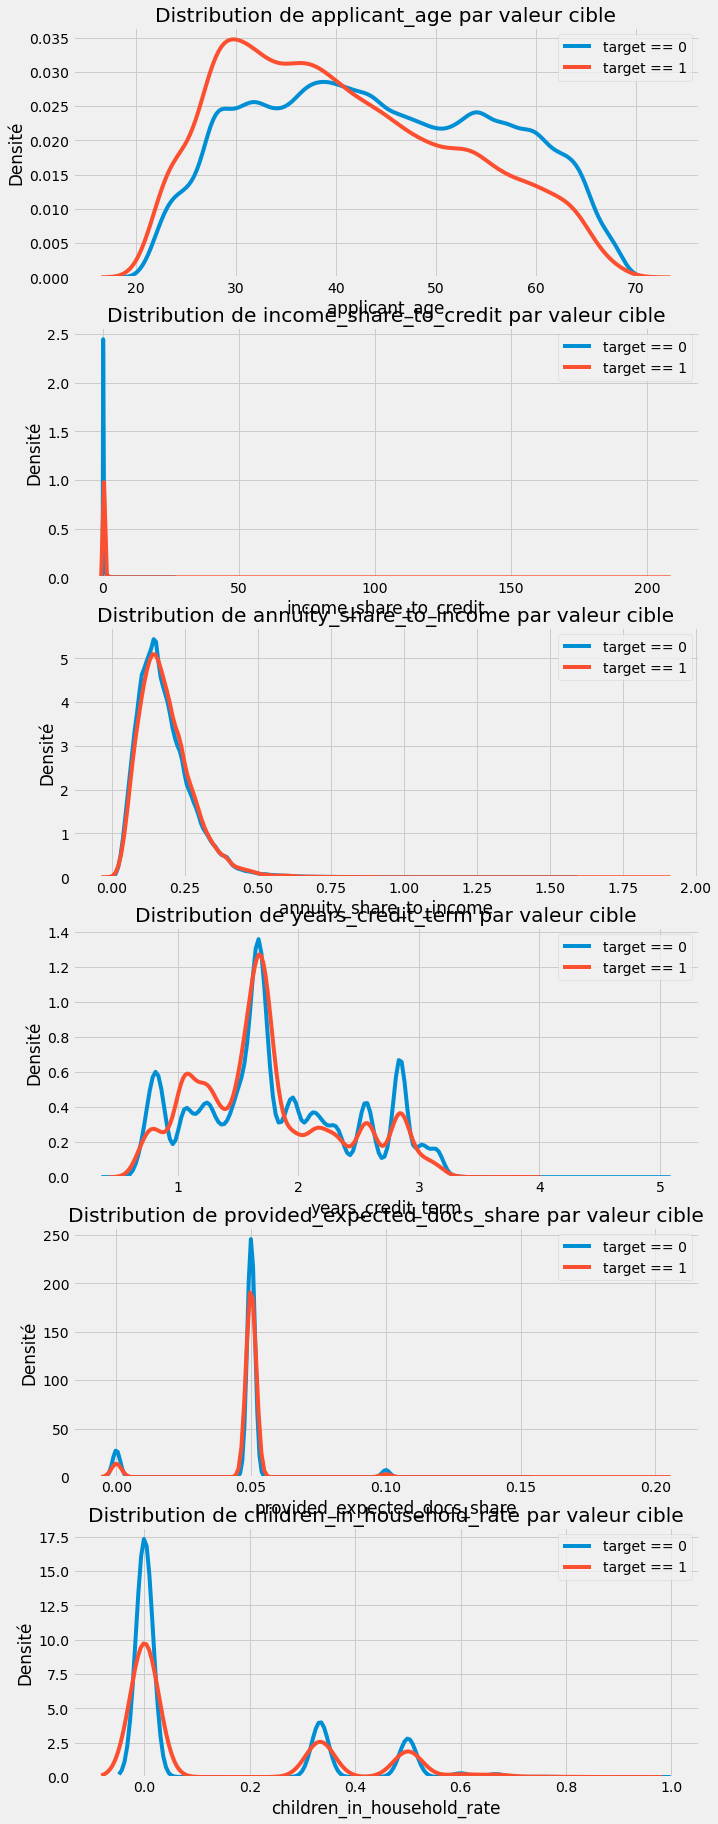

In [61]:
drawing_numerical_plots(app,numerical_created_features,6)

### Bureau & bureau_balance

In [62]:
bureau = dataframe[2]
bureau_balance = dataframe[3]

Afin d'améliorer notre modèle de machine learning, on peut inclure davantage d'informations provenant des autres fichiers de données fournis par l'entreprise ; ici, on va examiner l'utilisation des informations provenant des données bureau et bureau_balance : 
- **bureau** : informations sur les prêts antérieurs du client auprès d'autres institutions financières déclarées au Home Credit (chaque prêt antérieur a sa propre ligne)
- **bureau_balance** : informations mensuelles sur les prêts précédents (chaque mois a sa propre ligne)

Commençons par étudier le fichier 'bureau', qui semble contenir un nombre d'informations plus important

In [63]:
bureau.head(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


#### Principales informations

In [64]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [65]:
bureau.dtypes.value_counts()

float64    8
int64      6
object     3
dtype: int64

On constate que si la base de données **"bureau"** est beaucoup plus petite pour ce qui concerne son nombre de variables, **elle contient un plus grand nombre de lignes** (c'est lié au fait que chaque demandeur de crédit actuel peut avoir un grand historique de demandes de prêts dans d'autres instituts de crédit)

In [66]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [67]:
bureau_balance.dtypes.value_counts()

int64     2
object    1
dtype: int64

On se retrouve avec **la même problématique pour ce qui est de la deuxième base de données du Bureau** (cette fois lié à la mensualité des données présentes dans la base)

#### Nettoyage(s)

*Valeurs manquantes*

In [68]:
missing_values_table = missing_values(bureau)
missing_values_table.head(10)

,Valeurs manquantes,% du nombre total de valeurs
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


**2 colonnes sont particulièrement problématiques pour ce qui est de la base de données bureau, celles-ci contiennent un grand nombre de vides** ; de la même manière que précédemment pour la base de données principale, on décide de se fixer le même seuil pour supprimer ces colonnes avec un trop grand nombre de valeurs manquantes

In [69]:
delete_nan(bureau,0.4)

Index([], dtype='object')
Index([], dtype='object')
Index(['AMT_CREDIT_MAX_OVERDUE'], dtype='object')
Index(['AMT_CREDIT_MAX_OVERDUE'], dtype='object')
Index(['AMT_CREDIT_MAX_OVERDUE'], dtype='object')
Index(['AMT_CREDIT_MAX_OVERDUE'], dtype='object')
Index(['AMT_ANNUITY', 'AMT_CREDIT_MAX_OVERDUE'], dtype='object')


La base de données "bureau_balance" ne contient pas de valeurs manquantes et donc ne nécessite pas un tel traitement ; On peut remplir le restant des vides dans les colonnes numériques **avec la médiane de chaque colonne** dans la base de données

In [70]:
columns_list = bureau.select_dtypes(['float64','int64']).columns.tolist()
for column in columns_list :
     bureau[column] = bureau[column].fillna(bureau[column].median())

*Qualité des données fournies*

In [71]:
check_columns = bureau.select_dtypes(include =  ['float64','int64']).columns.tolist()
verify_quality(bureau,check_columns, minval = 0)

Ok pour la colonne 'SK_ID_CURR'
Ok pour la colonne 'SK_ID_BUREAU'
1716403 problèmes de qualité pour la colonne 'DAYS_CREDIT': [      0       1       2 ... 1716425 1716426 1716427] [ -497  -208  -203 ... -1809 -1878  -463]
Ok pour la colonne 'CREDIT_DAY_OVERDUE'
1112942 problèmes de qualité pour la colonne 'DAYS_CREDIT_ENDDATE': [      0       3       7 ... 1716425 1716426 1716427] [ -153.  -330. -1684. ... -1628. -1513.  -330.]
1716364 problèmes de qualité pour la colonne 'DAYS_ENDDATE_FACT': [      0       1       2 ... 1716425 1716426 1716427] [ -153.  -897.  -897. ...  -970. -1513.  -387.]
Ok pour la colonne 'CNT_CREDIT_PROLONG'
Ok pour la colonne 'AMT_CREDIT_SUM'
8418 problèmes de qualité pour la colonne 'AMT_CREDIT_SUM_DEBT': [     21      87      88 ... 1715271 1715929 1716375] [ -411.615 -2692.17   -149.04  ... -1066.275   -35.055   -35.865]
351 problèmes de qualité pour la colonne 'AMT_CREDIT_SUM_LIMIT': [   1966    7774   17054   17952   20661   23640   23642   23847   24511
 

On constate un certain nombre de problèmes lié à notre conception de la "qualité" des données fournies ; **il faut qu'on comprenne un peu mieux la signification de chaque variable** pour se faire notre propre opinion (en particulier sur les variables liées à des dates)

Comme noté précedemment, on se retrouve avec des **variables liées à des dates "négatives", on le traite rapidement ci-dessous**

In [72]:
bureau['DAYS_CREDIT'] = -bureau['DAYS_CREDIT']
bureau['DAYS_CREDIT_ENDDATE'] = -bureau['DAYS_CREDIT_ENDDATE']
bureau['DAYS_ENDDATE_FACT'] = -bureau['DAYS_ENDDATE_FACT']

On a donc encore deux autres variables qui font face à des problèmes de qualité (prennent des valeurs négatives) ; **il s'agit des variables 'AMT_CREDIT_SUM_DEBT' (qui logiquement est négative) et 'AMT_CREDIT_SUM_LIMIT'**, on le gardera en tête au cours de la suite de l'analyse si on est amené à utiliser ces variables

In [73]:
bureau.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE'],
      dtype='object')

Telles que décrites dans la base de description, **les variables contenues dans cette base de données sont les suivantes** :

In [74]:
def display_description(df):
    pd.set_option('max_colwidth', None)
    name = [x for x in globals() if globals()[x] is df][0]
    return description[description['Table'] == name+'.csv'].iloc[:,0:3]

In [75]:
display_description(bureau)

,Table,Row,Description
122,bureau.csv,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau"
123,bureau.csv,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)
124,bureau.csv,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits
125,bureau.csv,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit
126,bureau.csv,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit
127,bureau.csv,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample
128,bureau.csv,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit
129,bureau.csv,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit)
130,bureau.csv,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
131,bureau.csv,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged


On décide de **supprimer un certain nombre de variables, que l'on décide de ne pas utiliser par la suite**

In [76]:
bureau = bureau.drop(columns = ['CREDIT_CURRENCY',
                               'DAYS_ENDDATE_FACT',
                               'AMT_CREDIT_SUM_LIMIT',
                               'DAYS_CREDIT_UPDATE',
                               'AMT_CREDIT_SUM_DEBT'])

*Doublons*

In [77]:
bureau = bureau.drop_duplicates(keep = False)

#### Feature Engineering

*Variables numériques*

On décide de **créer des features à partir d'opérations mathématiques de base** sur nos variables initiales (telles que la somme ou le comptage)

In [78]:
def aggregate_numeric(df, group_var, df_name):
    
    # Retirer les variables d'ID hors des variables sur lesquelles on cherche à appliquer nos calculs
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Grouper pour chaque variable numérique et calculer les principales statistiques
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Création des noms de nos nouvelles colonnes
    columns = [group_var]

    # Itération sur les noms de nos variables
    for var in agg.columns.levels[0]:
        # Sauter la variable qui nous sert à faire le groupement
        if var != group_var:
            # Itération sur les variables dont on cherche à calculer les principales statistiques
            for stat in agg.columns.levels[1][:-1]:
                # Créer une nouvelle colonne pour la statistique et la variable
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [79]:
bureau_numeric_agg = aggregate_numeric(bureau.drop(columns = ['SK_ID_BUREAU']),'SK_ID_CURR','bureau')

In [80]:
bureau_numeric_agg.shape

(305811, 31)

On a donc créé une trentaine de nouvelles variables à partir de notre base bureau d'origine, mais toutes ne seront pas utiles/intéressantes pour notre analyse; **on conservera uniquement quelques variables (avec donc une ligne par demande de crédit actuel cette fois)**

In [81]:
bureau_agg_numeric_selection = bureau_numeric_agg[['SK_ID_CURR',
                                           'bureau_DAYS_CREDIT_count',
                                           'bureau_DAYS_CREDIT_mean',
                                           'bureau_CREDIT_DAY_OVERDUE_sum',
                                           'bureau_CNT_CREDIT_PROLONG_sum',
                                           'bureau_AMT_CREDIT_SUM_OVERDUE_sum']]

On décide d'utiliser telles qu'elles les variables déjà aggregées précédemment

In [82]:
# bureau_seniority_past_loans : ancienneté moyenne des crédits accordés à chaque client (en nombre d'année)
bureau_agg_numeric_selection['bureau_seniority_past_loans'] = bureau_agg_numeric_selection['bureau_DAYS_CREDIT_mean']/365

In [83]:
bureau_agg_numeric_selection = bureau_agg_numeric_selection.rename(columns = {'bureau_DAYS_CREDIT_count': 'bureau_count_past_loans',
                                                              'bureau_CNT_CREDIT_PROLONG_sum' : 'bureau_count_credit_prolongations'})

In [84]:
bureau_agg_numeric_selection[['bureau_count_past_loans',
                              'bureau_seniority_past_loans',
                              'bureau_count_credit_prolongations']].describe()

,bureau_count_past_loans,bureau_seniority_past_loans,bureau_count_credit_prolongations
count,305811.000000,305811.000000,305811.000000
mean,5.612709,2.969321,0.035980
std,4.430354,1.529976,0.232951
min,1.000000,0.000000,0.000000
25%,2.000000,1.836628,0.000000
50%,4.000000,2.883562,0.000000
75%,8.000000,3.920548,0.000000
max,116.000000,8.005479,9.000000


In [85]:
bureau_agg_numeric_selection = bureau_agg_numeric_selection.drop(columns = ['bureau_DAYS_CREDIT_mean',
                                                                            'bureau_CREDIT_DAY_OVERDUE_sum',
                                                                            'bureau_AMT_CREDIT_SUM_OVERDUE_sum'])

In [86]:
bureau_agg_numeric_selection.columns

Index(['SK_ID_CURR', 'bureau_count_past_loans',
       'bureau_count_credit_prolongations', 'bureau_seniority_past_loans'],
      dtype='object')

*Variables catégorielles*

Nous passons maintenant des colonnes numériques aux colonnes catégorielles ; **nous allons calculer le nombre de valeurs de chaque catégorie dans chaque variable catégorielle**

In [87]:
def aggregate_categorical(df,group_var):
    
    # Passer les colonnes liées à des données catégorielles sous la méthode de dummies
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]
    
    # Aggréger les données
    df_categorical_agg = categorical.groupby(group_var).agg(['count'])
    columns = []
    
    # Revoir le format du tableau
    for var in df_categorical_agg.columns.levels[0]:
        if var != group_var:
            for stat in ['count']:
                columns.append('%s_%s' % (var, stat))
    df_categorical_agg.columns = columns
    
    return df_categorical_agg

In [88]:
bureau_category_agg = aggregate_categorical(bureau,'SK_ID_CURR')
bureau_category_agg_selection = bureau_category_agg[['CREDIT_ACTIVE_Active_count']]

In [89]:
bureau_agg_selection = bureau_agg_numeric_selection.merge(bureau_category_agg_selection, on = 'SK_ID_CURR', how = 'left')

In [90]:
bureau_agg_selection['bureau_share_active_loans'] = bureau_agg_selection['CREDIT_ACTIVE_Active_count']/bureau_agg_selection['bureau_count_past_loans']
bureau_agg_selection = bureau_agg_selection.drop(columns = ['CREDIT_ACTIVE_Active_count'])

On peut maintenant **fusionner notre base de données principale avec la base de données bureau**

In [91]:
data_1 = app.merge(bureau_agg_selection, on = 'SK_ID_CURR', how = 'left')

On considérera que toutes les valeurs manquantes créées par cette fusion seront **liées aux clients qui n'avaient pas de précédent crédit**

In [92]:
columns_list = bureau_agg_selection.columns.tolist()
for column in columns_list :
    data_1[column] = data_1[column].fillna(0)

**On décide de ne pas utiliser la base de données 'bureau_balance' au cours de cet exercice**, car il ne s'agit que de la vision mensuelle de la base de données 'bureau', et **on doit en plus de cela considérer un nombre limité de variables** (pour des questions de temps de calcul)

In [93]:
data_1.columns.difference(app.columns)

Index(['bureau_count_credit_prolongations', 'bureau_count_past_loans',
       'bureau_seniority_past_loans', 'bureau_share_active_loans'],
      dtype='object')

On a donc rajouté sur notre base de données d'origine **4 nouvelles variables via la base de données bureau**

In [94]:
numerical_created_features = ['bureau_count_past_loans','bureau_count_credit_prolongations', 'bureau_seniority_past_loans']

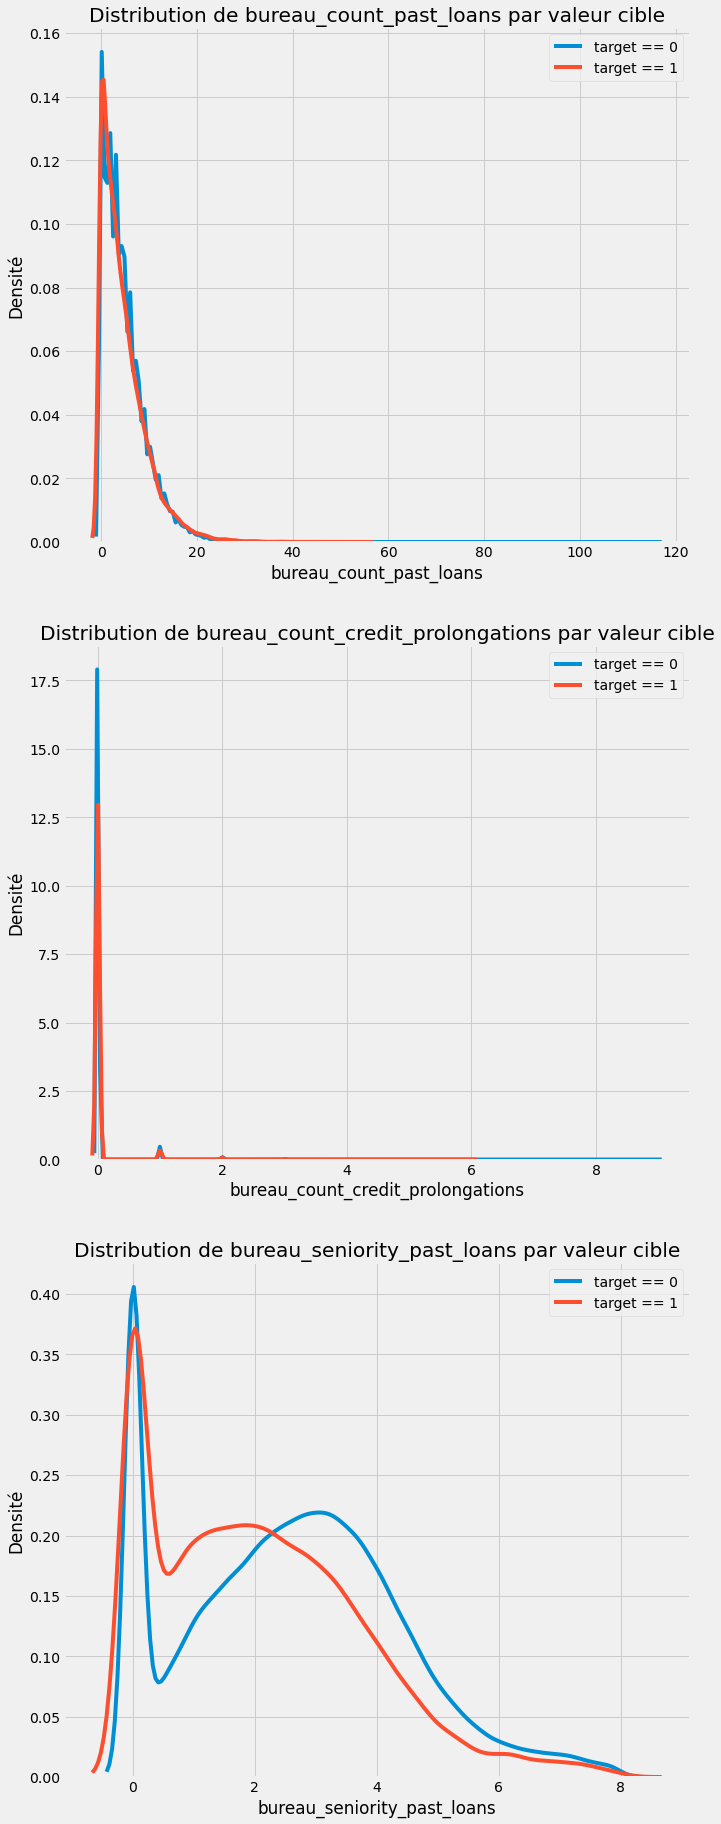

In [95]:
drawing_numerical_plots(data_1,numerical_created_features,3)

### Credit_card

Il nous reste encore **4 autres bases de données à traiter** ; toutes ne sont pas liées par les mêmes variables et par la même notion de temporalité également

In [96]:
credit_card_balance = dataframe[4]

Toujours dans l'ordre que nous avons fixé au départ, on peut poursuivre en étudiant le **fichier "credit_card"** et ce qu'il contient ; on sait qu'en fait, **il contient différentes données mensuelles sur l'utilisation des cartes de crédits que les clients ont utilisées avec Home Credit** (une seule carte de crédit peut donc représenter plusieurs lignes à la fois)

In [97]:
credit_card_balance.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


#### Principales informations

Avant de démarrer l'analyse en tant que telle des bases de données restantes, **rappelons quelques éléments chiffrés à propos des différents id clients**

In [98]:
app.shape

(356255, 26)

In [99]:
bureau['SK_ID_CURR'].nunique()

305811

In [100]:
bureau['SK_ID_BUREAU'].nunique()

1716428

Ici, on peut re-dire que :
- **SK_ID_CURR** : id de la demande de prêt actuelle (dont on cherche à déterminer la probabilité de non remboursement) ; on en dénombre à peu près 356k dans notre base de données principale, alors qu'on en compte 305k dans notre base de données bureau (ce qui signifie que la grande majorité des clients ont déjà contracté un ou plusieurs prêt(s) précédent(s) auprès du Bureau)
- **SK_ID_BUREAU** : id des demandes précédentes de crédit auprès du Bureau ; on peut ainsi dire qu'au total environ 1,7M de prêts précédents ont été contractés (**ce qui fait environ 5,6 demandes de crédits en historique par client**)

In [101]:
credit_card_balance.shape

(3840312, 23)

In [102]:
credit_card_balance['SK_ID_CURR'].nunique()

103558

Si le fichier **'credit_card'** est beaucoup plus volumineux que les précédents (parce qu'une ligne = un mois et potentiellement plusieurs lignes par mois par carte de crédit), on peut souligner d'emblée que **tous les clients ayant demandé un prêt auprès de notre institut ne possèdent pas nécessairement une carte de crédit que nous leur avons fourni** (cela concerne environ 1 client sur 3, sur le total des clients qui ont fait une demande de prêt)

On l'a dit, dans ce fichier, une ligne correspond à un mois d'analyse ; **c'est pourquoi on va sélectionner des données récentes** (pour décider si actuellement on peut, ou pas, croire ce client et décider de lui proposer un prêt), sous la forme d'une année entière

In [103]:
credit_card_balance['MONTHS_BALANCE'].value_counts()

-4     102115
-5     100546
-3     100355
-6      98577
-7      95332
        ...  
-92     14911
-93     14197
-94     13397
-95     12521
-96     11722
Name: MONTHS_BALANCE, Length: 96, dtype: int64

On constate qu'effectivement **tous les clients ne sont pas répartis équitablement sur tous les mois considérés dans cette base de données** (parce qu'effectivement certains sont plus ou moins récents) ; de plus, **les clients les plus vieux sont visiblement les moins nombreux**

**On décide de créer deux variables importantes ici**:
- count_negative_bank_balance : nombre de fois que le solde du compte a été négatif
- applicant_bank_account_seniority : information d'ancienneté (car le fait de prendre une carte de crédit chez nous correspond sans doute au moment où ils sont rentrés dans notre base de données et donc quand ils sont devenus nos clients)

In [104]:
# count_negative_bank_balance
credit_card_balance['count_negative_bank_balance'] = np.where(credit_card_balance['AMT_BALANCE'] < 0, 1, 0)
df1 = credit_card_balance[['SK_ID_CURR','count_negative_bank_balance']].groupby('SK_ID_CURR').agg({'count_negative_bank_balance': ['sum']}).reset_index()

In [105]:
# applicant_bank_account_seniority
df2 = credit_card_balance.groupby('SK_ID_CURR').agg({'MONTHS_BALANCE': ['min']}).reset_index()
credit_card_agg = df1.merge(df2, left_on = 'SK_ID_CURR', right_on = 'SK_ID_CURR').droplevel(axis = 1, level = 1)
credit_card_agg['applicant_bank_account_seniority'] = -credit_card_agg['MONTHS_BALANCE']/12
credit_card_agg = credit_card_agg.drop(columns = ['MONTHS_BALANCE'])

Pour ce qui est du reste des colonnes dans cette base de données, **on se concentrera sur les données récentes (les deux années passées)** comme précisé précédemment et sur les données différentes de 0 (car cela signifie peut être que le client n'a rien mis comme argent à ce moment là sur son compte et donc cela nous intéresse moins)

In [106]:
selected_months = np.arange(-24, 0, 1).tolist()

In [107]:
recent_credit_card = credit_card_balance[credit_card_balance['MONTHS_BALANCE'].isin(selected_months) & (credit_card_balance['AMT_BALANCE'] != 0)]

In [108]:
recent_credit_card.shape

(605531, 24)

Rien que par cette opération, **on a environ divisé par 2 le nombre total de lignes considérées** dans cette base de données

#### Nettoyages

*Valeurs manquantes*

In [109]:
missing_values_table = missing_values(recent_credit_card)
missing_values_table.head(10)

,Valeurs manquantes,% du nombre total de valeurs
AMT_PAYMENT_CURRENT,23785,3.9
AMT_INST_MIN_REGULARITY,1065,0.2
CNT_INSTALMENT_MATURE_CUM,1065,0.2
AMT_DRAWINGS_ATM_CURRENT,194,0.0
AMT_DRAWINGS_OTHER_CURRENT,194,0.0
AMT_DRAWINGS_POS_CURRENT,194,0.0
CNT_DRAWINGS_ATM_CURRENT,194,0.0
CNT_DRAWINGS_OTHER_CURRENT,194,0.0
CNT_DRAWINGS_POS_CURRENT,194,0.0


**Les colonnes de la base de données 'credit_card' sont globalement assez bien remplies** (pas de colonnes avec des manquants de plus de 40%, seuil qu'on a défini comme étant raisonnable précédemment) ; **on remplit donc les valeurs manquantes avec la médiane de chaque colonne**

In [110]:
columns_list = recent_credit_card.select_dtypes(['float64','int64']).columns.tolist()
for column in columns_list :
     recent_credit_card[column] = recent_credit_card[column].fillna(recent_credit_card[column].median())

*Qualité des données*

In [111]:
recent_credit_card['MONTHS_BALANCE'] = -recent_credit_card['MONTHS_BALANCE']

In [112]:
check_columns = recent_credit_card.select_dtypes(include = ['float64','int64']).columns.tolist()
verify_quality(recent_credit_card,check_columns, minval = 0)

Ok pour la colonne 'SK_ID_PREV'
Ok pour la colonne 'SK_ID_CURR'
Ok pour la colonne 'MONTHS_BALANCE'
Ok pour la colonne 'AMT_BALANCE'
Ok pour la colonne 'AMT_CREDIT_LIMIT_ACTUAL'
Ok pour la colonne 'AMT_DRAWINGS_ATM_CURRENT'
Ok pour la colonne 'AMT_DRAWINGS_CURRENT'
Ok pour la colonne 'AMT_DRAWINGS_OTHER_CURRENT'
Ok pour la colonne 'AMT_DRAWINGS_POS_CURRENT'
Ok pour la colonne 'AMT_INST_MIN_REGULARITY'
Ok pour la colonne 'AMT_PAYMENT_CURRENT'
Ok pour la colonne 'AMT_PAYMENT_TOTAL_CURRENT'
Ok pour la colonne 'AMT_RECEIVABLE_PRINCIPAL'
Ok pour la colonne 'AMT_RECIVABLE'
Ok pour la colonne 'AMT_TOTAL_RECEIVABLE'
Ok pour la colonne 'CNT_DRAWINGS_ATM_CURRENT'
Ok pour la colonne 'CNT_DRAWINGS_CURRENT'
Ok pour la colonne 'CNT_DRAWINGS_OTHER_CURRENT'
Ok pour la colonne 'CNT_DRAWINGS_POS_CURRENT'
Ok pour la colonne 'CNT_INSTALMENT_MATURE_CUM'
Ok pour la colonne 'SK_DPD'
Ok pour la colonne 'SK_DPD_DEF'


Les données contenues dans cette base de données sont de bonne qualité selon les critères que nous avons défini et **ne nécessitent pas de traitement "manuel"** ; avant de passer à la phase de feature engineering, re-définissons les données contenues dans cette base

In [113]:
display_description(credit_card_balance)

,Table,Row,Description
150,credit_card_balance.csv,SK_ID_PREV,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)"
151,credit_card_balance.csv,SK_ID_CURR,ID of loan in our sample
152,credit_card_balance.csv,MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date)
153,credit_card_balance.csv,AMT_BALANCE,Balance during the month of previous credit
154,credit_card_balance.csv,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the previous credit
155,credit_card_balance.csv,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the previous credit
156,credit_card_balance.csv,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previous credit
157,credit_card_balance.csv,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of the previous credit
158,credit_card_balance.csv,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the month of the previous credit
159,credit_card_balance.csv,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the previous credit


*Doublons*

In [114]:
recent_credit_card = recent_credit_card.drop_duplicates(keep = False)

#### Feature Engineering

*Variables numériques*

Etant donné la **compréhension que nous avons des colonnes citées précédemment**, et de manière ainsi intuitive, nous aimerions tirer les variables suivantes de cette base de données credit_card :
- Ancienneté des clients dans notre institut, via l'ancienneté de l'utilisation de la carte de crédit (*déjà créée*)
- Solde moyen disponible sur le compte du client
- Limite max de retrait
- Pourcentage de montant prélevé (dont autres prélevements) vs les montants retirés par le client
- Nombre cumulé de jours de retards de paiement
- Part du versement effectué pour le crédit sur le total

Pour obtenir ces différentes variables, on aura **besoin que d'un nombre limité de colonnes, conservées ci-dessous**

In [115]:
recent_credit_card = recent_credit_card[['SK_ID_CURR',
                                         'AMT_BALANCE',
                                         'AMT_CREDIT_LIMIT_ACTUAL',
                                         'AMT_DRAWINGS_ATM_CURRENT',
                                         'AMT_DRAWINGS_CURRENT',
                                         'AMT_DRAWINGS_OTHER_CURRENT',
                                         'AMT_INST_MIN_REGULARITY',
                                         'AMT_PAYMENT_TOTAL_CURRENT',
                                         'SK_DPD']]

In [116]:
recent_credit_card_agg = aggregate_numeric(recent_credit_card, group_var = 'SK_ID_CURR', df_name = 'recent_credit_card')

In [117]:
# avg_amount_available_bank_account : solde moyen disponible sur le compte du client
recent_credit_card_agg = recent_credit_card_agg.rename(columns = {'recent_credit_card_AMT_BALANCE_mean': 
                                                                  'avg_amount_available_bank_account'})

In [118]:
# withdrawal_limit_bank_account : montant max de retrait par le client
recent_credit_card_agg = recent_credit_card_agg.rename(columns = {'recent_credit_card_AMT_CREDIT_LIMIT_ACTUAL_max': 
                                                                  'withdrawal_limit_bank_account'})

In [119]:
# ratio_withdrawn_vs_collected : montant max de retrait par le client
recent_credit_card_agg['ratio_withdrawn_vs_collected'] = recent_credit_card_agg['recent_credit_card_AMT_DRAWINGS_ATM_CURRENT_sum'] / (recent_credit_card_agg['recent_credit_card_AMT_DRAWINGS_CURRENT_sum'] + recent_credit_card_agg['recent_credit_card_AMT_DRAWINGS_OTHER_CURRENT_sum'])

In [120]:
# cumulative_number_of_days_late : montant max de retrait par le client
recent_credit_card_agg = recent_credit_card_agg.rename(columns = {'recent_credit_card_SK_DPD_sum': 
                                                                  'cumulative_number_of_days_late'})

In [121]:
recent_credit_card_agg = recent_credit_card_agg[['SK_ID_CURR',
                                                 'avg_amount_available_bank_account',
                                                 'withdrawal_limit_bank_account',
                                                 'ratio_withdrawn_vs_collected',
                                                 'cumulative_number_of_days_late']]

On peut maintenant **fusionner notre base de données principale avec la base de données credit_balance**

In [122]:
credit_card_agg = credit_card_agg.merge(recent_credit_card_agg, on = 'SK_ID_CURR', how = 'left')

In [123]:
data_2 = data_1.merge(credit_card_agg, on = 'SK_ID_CURR', how = 'left')

On considérera que toutes les valeurs manquantes créées par cette fusion seront **liées aux clients qui n'avaient pas de précédente carte de crédit**

In [124]:
columns_list = credit_card_agg.columns.tolist()
for column in columns_list :
    data_2[column] = data_2[column].fillna(0)

In [125]:
data_2.columns.difference(data_1.columns)

Index(['applicant_bank_account_seniority', 'avg_amount_available_bank_account',
       'count_negative_bank_balance', 'cumulative_number_of_days_late',
       'ratio_withdrawn_vs_collected', 'withdrawal_limit_bank_account'],
      dtype='object')

On a donc rajouté **6 variables à la suite des précédents traitements effectués** sur la base de données 'credit_card'

In [126]:
data_2[['applicant_bank_account_seniority', 'avg_amount_available_bank_account',
       'count_negative_bank_balance', 'cumulative_number_of_days_late',
       'ratio_withdrawn_vs_collected', 'withdrawal_limit_bank_account']].describe()

,applicant_bank_account_seniority,avg_amount_available_bank_account,count_negative_bank_balance,cumulative_number_of_days_late,ratio_withdrawn_vs_collected,withdrawal_limit_bank_account
count,356255.000000,3.562550e+05,356255.000000,356255.000000,356255.000000,3.562550e+05
mean,0.909227,2.297902e+04,0.006582,56.859716,0.076656,4.238231e+04
std,2.065538,7.864191e+04,0.193780,1233.710668,0.243549,1.307114e+05
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
50%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
75%,0.666667,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
max,8.000000,1.125000e+06,8.000000,62046.000000,1.000000,1.350000e+06


In [127]:
numerical_created_features = ['applicant_bank_account_seniority', 
                              'avg_amount_available_bank_account',
                              'count_negative_bank_balance',
                              'cumulative_number_of_days_late',
                              'ratio_withdrawn_vs_collected',
                              'withdrawal_limit_bank_account']

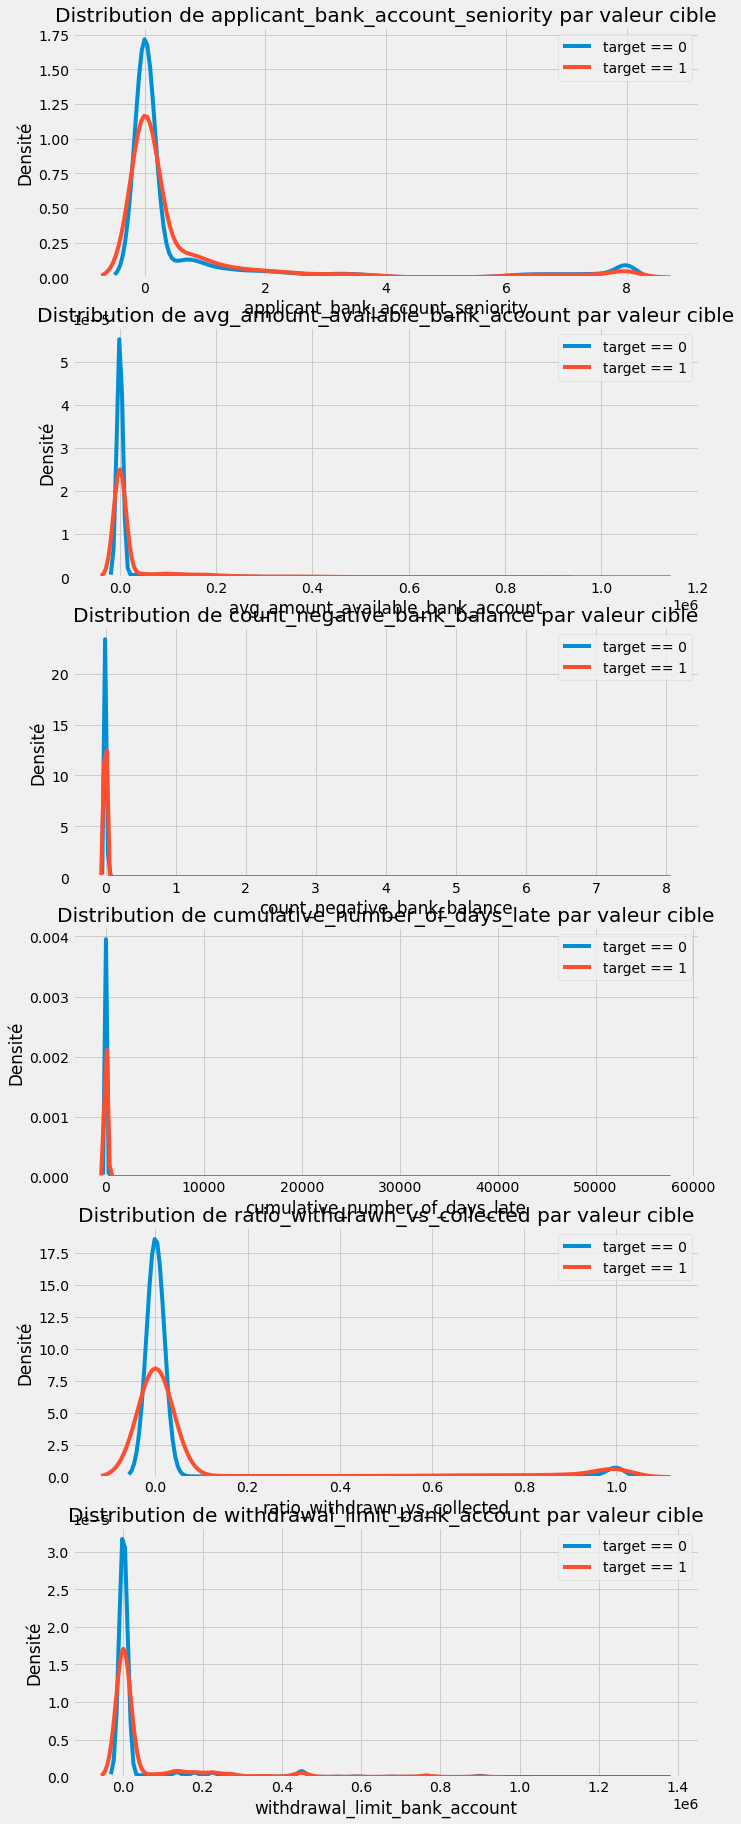

In [128]:
drawing_numerical_plots(data_2,numerical_created_features,6)

### Installments_payments

Passons maintenant à la **base de données "installments_payments"**, qui concerne **l'historique des paiements pour les prêts précédents chez Home Credit** (il y a donc une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué)

In [129]:
installments_payments = dataframe[5]

In [130]:
installments_payments.head(5)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


#### Principales informations

In [131]:
installments_payments.shape

(13605401, 8)

Tout comme la base de données credit_card_balance, **cette base de données est beaucoup plus imposante en termes de nombre de lignes**, parce qu'une ligne = un paiement (il est donc logique qu'il y en ait beaucoup plus que de nombre de clients) 

In [132]:
installments_payments['SK_ID_CURR'].nunique()

339587

In [133]:
data_1['SK_ID_CURR'].nunique()

356255

**Quasiment tous les clients ayant demandé actuellement un prêt avaient déjà demandé un prêt chez Home Credit** (la différence est minime, de l'ordre des 20k clients)

In [134]:
installments_payments.dtypes.value_counts()

float64    5
int64      3
dtype: int64

**Cette base de données n'est constituée que de variables numériques** et ne nécessitera pas de traitements liés à des variables catégorielles

#### Nettoyages

*Valeurs manquantes*

In [135]:
missing_values_table = missing_values(installments_payments)
missing_values_table.head(10)

,Valeurs manquantes,% du nombre total de valeurs
DAYS_ENTRY_PAYMENT,2905,0.0
AMT_PAYMENT,2905,0.0


Cette base de données est globalement très bien remplie et **ne présente pas de fort taux de valeurs manquantes** (on remplacera néanmoins les quelques valeurs manquantes par la médiane de la colonne correspondante)

In [136]:
columns_list = installments_payments.select_dtypes(['float64','int64']).columns.tolist()
for column in columns_list :
     installments_payments[column] = installments_payments[column].fillna(installments_payments[column].median())

*Qualité des données*

In [137]:
check_columns = installments_payments.select_dtypes(include = ['float64','int64']).columns.tolist()
verify_quality(installments_payments,check_columns, minval = 0)

Ok pour la colonne 'SK_ID_PREV'
Ok pour la colonne 'SK_ID_CURR'
Ok pour la colonne 'NUM_INSTALMENT_VERSION'
Ok pour la colonne 'NUM_INSTALMENT_NUMBER'
13605401 problèmes de qualité pour la colonne 'DAYS_INSTALMENT': [       0        1        2 ... 13605398 13605399 13605400] [-1180. -2156.   -63. ...    -7. -1986.   -27.]
13605401 problèmes de qualité pour la colonne 'DAYS_ENTRY_PAYMENT': [       0        1        2 ... 13605398 13605399 13605400] [-1187. -2156.   -63. ...  -827.  -827.  -827.]
Ok pour la colonne 'AMT_INSTALMENT'
Ok pour la colonne 'AMT_PAYMENT'


Tout comme les précédents fichiers, **ce sont particulièrement les variables liées aux dates qui contiennent des valeurs négatives** et qui nécessitent un traitement afin de prévenir les erreurs de compréhension

In [138]:
installments_payments['MONTHS_INSTALMENT'] = installments_payments['DAYS_INSTALMENT'] / -12
installments_payments['MONTHS_ENTRY_PAYMENT'] = installments_payments['DAYS_ENTRY_PAYMENT'] / -12

In [139]:
installments_payments.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT', 'MONTHS_INSTALMENT',
       'MONTHS_ENTRY_PAYMENT'],
      dtype='object')

In [140]:
display_description(installments_payments)

,Table,Row,Description
211,installments_payments.csv,SK_ID_PREV,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)"
212,installments_payments.csv,SK_ID_CURR,ID of loan in our sample
213,installments_payments.csv,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
214,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment
215,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was supposed to be paid (relative to application date of current loan)
216,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit paid actually (relative to application date of current loan)
217,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of previous credit on this installment
218,installments_payments.csv,AMT_PAYMENT,What the client actually paid on previous credit on this installment


*Doublons*

In [141]:
installments_payments = installments_payments.drop_duplicates(keep = False)

#### Feature Engineering

*Variables numériques*

On va créer **deux sortes de variables ici**, d'une part **une variable liée à la différence de paiement** (en montant d'argent) et d'autres part **une variable liée aux mois de retards observés pour chaque client** (en nombre de mois)

In [142]:
installments_payments = installments_payments[['SK_ID_CURR',
                                               'SK_ID_PREV',
                                               'AMT_PAYMENT',
                                               'AMT_INSTALMENT',
                                               'MONTHS_ENTRY_PAYMENT',
                                               'MONTHS_INSTALMENT']]

In [143]:
installments_payments_agg = aggregate_numeric(installments_payments.drop(columns = ['SK_ID_PREV']), group_var = 'SK_ID_CURR', df_name = 'installments_payments')

In [144]:
# previous_prescribed_paid_installment : différence pour chaque versement (entre le montant payé prescrit et valeur du versement)
installments_payments_agg['previous_difference_paid_installment'] = installments_payments_agg['installments_payments_AMT_INSTALMENT_sum'] - installments_payments_agg['installments_payments_AMT_PAYMENT_sum']

In [145]:
# previous_difference_months_installment : différence de temps pour chaque paiement (jamais de négatif)
installments_payments_agg['previous_difference_months_installment'] = installments_payments_agg['installments_payments_MONTHS_INSTALMENT_sum'] - installments_payments_agg['installments_payments_MONTHS_ENTRY_PAYMENT_sum']
installments_payments_agg['previous_difference_months_installment'] = installments_payments_agg['previous_difference_months_installment'].apply(lambda x: x if x > 0 else 0)

In [146]:
selection_installments_payments_agg = installments_payments_agg[['SK_ID_CURR',
                                                                 'previous_difference_paid_installment',
                                                                 'previous_difference_months_installment']]

In [147]:
data_3 = data_2.merge(selection_installments_payments_agg, on = 'SK_ID_CURR', how = 'left')

In [148]:
columns_list = credit_card_agg.columns.tolist()
for column in columns_list :
    data_3[column] = data_3[column].fillna(0)

In [149]:
data_3.columns.difference(data_2.columns)

Index(['previous_difference_months_installment', 'previous_difference_paid_installment'], dtype='object')

On a donc rajouté **deux variables à notre base de données principale**

In [150]:
data_3[['previous_difference_months_installment', 'previous_difference_paid_installment']].describe()

,previous_difference_months_installment,previous_difference_paid_installment
count,339587.000000,3.395870e+05
mean,1.257794,-7.426787e+03
std,26.924212,1.780175e+05
min,0.000000,-4.417384e+06
25%,0.000000,0.000000e+00
50%,0.000000,0.000000e+00
75%,0.000000,1.570941e+04
max,6908.750000,3.037736e+06


In [151]:
numerical_created_features = ['previous_difference_months_installment', 'previous_difference_paid_installment']

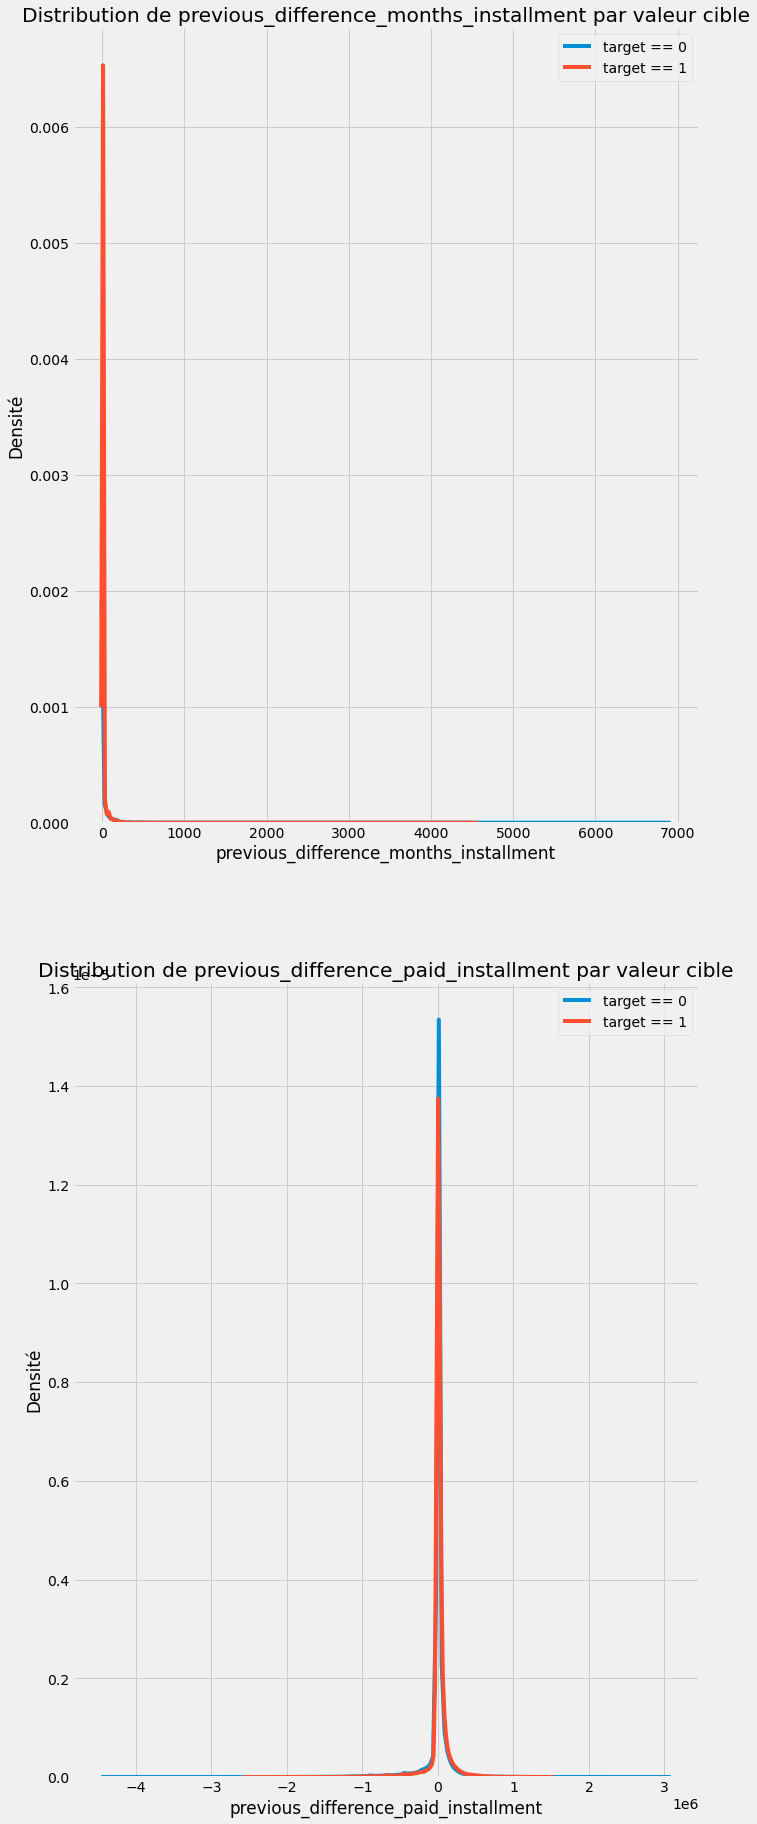

In [152]:
drawing_numerical_plots(data_3,numerical_created_features,2)

### Cash_balance

In [153]:
POS_CASH_balance = dataframe[6]

Cette base de données 'POS_CASH_balance' contient les données sur les **instantanés des soldes mensuels des prêts POS** (point of sales) et cash précédents que le demandeur a eu avec Home Credit ; **ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans Home Credit** (crédit à la consommation et prêts au comptant) lié aux prêts de notre échantillon (c'est-à-dire que le tableau comporte (#prêts dans l'échantillon # de crédits précédents relatifs # de mois dans lesquels nous avons un historique observable pour les crédits précédents) lignes)

In [154]:
POS_CASH_balance.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [155]:
POS_CASH_balance['SK_ID_CURR'].nunique()

337252

In [156]:
installments_payments['SK_ID_CURR'].nunique()

339587

In [157]:
data_3['SK_ID_CURR'].nunique()

356255

On constate que cette base de données contient des informations que nous avons globalement déjà inséré, on n'insérera pas de nouvelles variables à partir de cette base ci (toujours dans le but d'avoir un nombre limité de variables à la fin)

### Previous_application

In [158]:
previous_application = dataframe[7]

Cette base de données **'previous_application'** nous permet de comprendre **la nature des demandes de prêt précédentes au Home Credit** (chaque prêt actuel dans les données de demande peut avoir plusieurs prêts précédents, chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV)

In [159]:
previous_application.head(5)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


#### Principales informations

In [160]:
previous_application.shape

(1670214, 37)

Cette base de données contient un **grand nombre de lignes (on a expliqué plus haut pourquoi)**, mais surtout un grand nombre de features (sans aucun traitement, elle en possède 37) ; l'objet de cette partie sera donc surtout d'**identifier quelles variables seront les plus intéressantes pour notre étude**

In [161]:
previous_application['SK_ID_CURR'].nunique()

338857

La **base de données 'previous_application' contient environ 338k demandes de prêt actuelles clients uniques** (ce qui signifie que 338k clients/350k ont déjà un prêt précédent chez Home Credit), ce qui est cohérent avec les données trouvées précédemment dans les autres bases

In [162]:
data_3.shape

(356255, 38)

On rappelera ici qu'on a déjà mis en place 39 variables et que nous devrons encore effectuer des tris, pour conserver aux alentours de 20 variables (**plus simple en termes d'interpretabilité**)

#### Nettoyages

*Valeurs manquantes*

In [163]:
missing_values_table = missing_values(previous_application)
missing_values_table.head(10)

,Valeurs manquantes,% du nombre total de valeurs
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3
DAYS_LAST_DUE_1ST_VERSION,673065,40.3
DAYS_LAST_DUE,673065,40.3
DAYS_TERMINATION,673065,40.3


In [164]:
delete_nan(previous_application,0.4)

Index([], dtype='object')
Index([], dtype='object')
Index(['AMT_DOWN_PAYMENT'], dtype='object')
Index(['AMT_DOWN_PAYMENT'], dtype='object')
Index(['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT'], dtype='object')
Index(['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY'], dtype='object')
Index(['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED'],
      dtype='object')
Index(['AMT_DOWN_PAYMENT', 'NAME_TYPE_SUITE', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED'],
      dtype='object')
Index(['AMT_DOWN_PAYMENT', 'NAME_TYPE_SUITE', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED'],
      dtype='object')
Index(['AMT_DOWN_PAYMENT', 'NAME_TYPE_SUITE', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED'],
      dtype='object')
Index(['AMT_DOWN_PAYMENT', 'DAYS_FIRST_DRAWING', 'NAME_TYPE_SUITE',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
   

In [165]:
previous_application.shape

(1670214, 26)

Rien qu'avec cette première opération, on a déjà pu **supprimer 11 variables qui contenaient un trop grand nombre de valeurs manquantes** et qui n'étaient donc pas utilisables en l'état

Comme effectué précedemment, on peut remplir le restant des vides dans les colonnes numériques **avec la médiane de chaque colonne**

In [166]:
columns_list = previous_application.select_dtypes(['float64','int64']).columns.tolist()
for column in columns_list :
     previous_application[column] = previous_application[column].fillna(previous_application[column].median())

*Qualité des données fournies*

In [167]:
check_columns = previous_application.select_dtypes(include =  ['float64','int64']).columns.tolist()
verify_quality(previous_application,check_columns, minval = 0)

Ok pour la colonne 'SK_ID_PREV'
Ok pour la colonne 'SK_ID_CURR'
Ok pour la colonne 'AMT_ANNUITY'
Ok pour la colonne 'AMT_APPLICATION'
Ok pour la colonne 'AMT_CREDIT'
Ok pour la colonne 'AMT_GOODS_PRICE'
Ok pour la colonne 'HOUR_APPR_PROCESS_START'
Ok pour la colonne 'NFLAG_LAST_APPL_IN_DAY'
1670214 problèmes de qualité pour la colonne 'DAYS_DECISION': [      0       1       2 ... 1670211 1670212 1670213] [  -73  -164  -301 ... -1488 -1185 -1193]
762675 problèmes de qualité pour la colonne 'SELLERPLACE_AREA': [      1       2       3 ... 1670200 1670212 1670213] [-1 -1 -1 ... -1 -1 -1]
Ok pour la colonne 'CNT_PAYMENT'


Ici, **on supprime les variables dont on sait qu'elles ne nous seront pas utiles pour le reste de l'analyse** (en plus du fait qu'elles contiennent un certain nombre de valeurs problématiques)

In [168]:
previous_application = previous_application.drop(columns = ['AMT_GOODS_PRICE',
                                                            'WEEKDAY_APPR_PROCESS_START',
                                                            'HOUR_APPR_PROCESS_START',
                                                            'FLAG_LAST_APPL_PER_CONTRACT',
                                                            'NFLAG_LAST_APPL_IN_DAY',
                                                            'SELLERPLACE_AREA'])

In [169]:
previous_application.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION'],
      dtype='object')

In [170]:
display_description(previous_application)

,Table,Row,Description
173,previous_application.csv,SK_ID_PREV,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit)"
174,previous_application.csv,SK_ID_CURR,ID of loan in our sample
175,previous_application.csv,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application"
176,previous_application.csv,AMT_ANNUITY,Annuity of previous application
177,previous_application.csv,AMT_APPLICATION,For how much credit did client ask on the previous application
178,previous_application.csv,AMT_CREDIT,"Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT"
179,previous_application.csv,AMT_DOWN_PAYMENT,Down payment on the previous application
180,previous_application.csv,AMT_GOODS_PRICE,Goods price of good that client asked for (if applicable) on the previous application
181,previous_application.csv,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for previous application
182,previous_application.csv,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client apply for the previous application


*Doublons*

In [171]:
previous_application = previous_application.drop_duplicates(keep = False)

#### Feature Engineering

*Variables numériques*

In [172]:
previous_application.select_dtypes(include =  ['float64','int64']).columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION',
       'AMT_CREDIT', 'DAYS_DECISION', 'CNT_PAYMENT'],
      dtype='object')

Le **nombre de variables numérique** dans cette base de données reste **relativement limité**, on voit rapidement les variables qu'on aimerait créer :
- **previous_application_accepted_share** : part du crédit accordé par la banque sur le total demandé par le client (%)
- **previous_application_credit_term** : terme du crédit précédent, obtenu en divisant le crédit total précédent par le nombre d'annuité (mois)

In [173]:
previous_application_numerical_selection = previous_application[['SK_ID_CURR',
                                                                 'AMT_ANNUITY',
                                                                 'AMT_APPLICATION',
                                                                 'AMT_CREDIT']]

In [174]:
previous_application_numerical_agg = aggregate_numeric(previous_application_numerical_selection,'SK_ID_CURR','previous_application')

In [175]:
previous_application_numerical_agg.shape

(338857, 16)

In [176]:
previous_application_numerical_agg['previous_application_accepted_share'] = previous_application_numerical_agg['previous_application_AMT_APPLICATION_sum']/previous_application_numerical_agg['previous_application_AMT_CREDIT_sum']

In [177]:
previous_application_numerical_agg['previous_application_credit_term'] = previous_application_numerical_agg['previous_application_AMT_CREDIT_sum']/previous_application_numerical_agg['previous_application_AMT_ANNUITY_sum']

In [178]:
previous_application_numerical_agg[['previous_application_accepted_share','previous_application_credit_term']].describe()

,previous_application_accepted_share,previous_application_credit_term
count,338605.000000,338856.000000
mean,0.936132,11.317062
std,0.188629,5.397516
min,0.000000,0.000000
25%,0.886772,7.527625
50%,0.949845,10.069983
75%,1.003571,14.404991
max,10.000000,65.376786


In [179]:
previous_application_numerical_agg = previous_application_numerical_agg[['SK_ID_CURR',
                                                                         'previous_application_accepted_share',
                                                                         'previous_application_credit_term']]

*Variables catégorielles*

In [180]:
previous_application.select_dtypes(include = ['object']).columns

Index(['NAME_CONTRACT_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION'],
      dtype='object')

Le nombre de variables catégorielles est très élevé relativement à ce que l'on souhaite obtenir, **il va falloir qu'on réduise leur nombre**

In [181]:
previous_application_categorical_selection = previous_application[['SK_ID_CURR',
                                                                   'NAME_CONTRACT_STATUS']]

In [182]:
previous_application_categorical_agg = previous_application_categorical_selection.groupby(['SK_ID_CURR','NAME_CONTRACT_STATUS']).size().unstack(fill_value=0)
previous_application_categorical_agg = previous_application_categorical_agg.reset_index().rename_axis(None,axis = 1)

In [183]:
previous_application_categorical_agg['sum'] = previous_application_categorical_agg.iloc[:,1:5].sum(axis = 1)

In [184]:
previous_application_categorical_agg['share_previous_refused_applications'] = previous_application_categorical_agg['Refused'] / previous_application_categorical_agg['sum']

In [185]:
previous_application_categorical_agg = previous_application_categorical_agg[['SK_ID_CURR',
                                                                             'share_previous_refused_applications']]

In [186]:
previous_application_selection = previous_application_numerical_agg.merge(previous_application_categorical_agg, on = 'SK_ID_CURR', how = 'left')

In [187]:
data = data_3.merge(previous_application_selection, on = 'SK_ID_CURR', how = 'left')

In [188]:
columns_list = previous_application_selection.columns.tolist()
for column in columns_list :
    data[column] = data[column].fillna(0)

In [189]:
data.columns.difference(data_3.columns)

Index(['previous_application_accepted_share',
       'previous_application_credit_term',
       'share_previous_refused_applications'],
      dtype='object')

In [190]:
numerical_created_features = ['previous_application_accepted_share',
                              'previous_application_credit_term',
                              'share_previous_refused_applications']

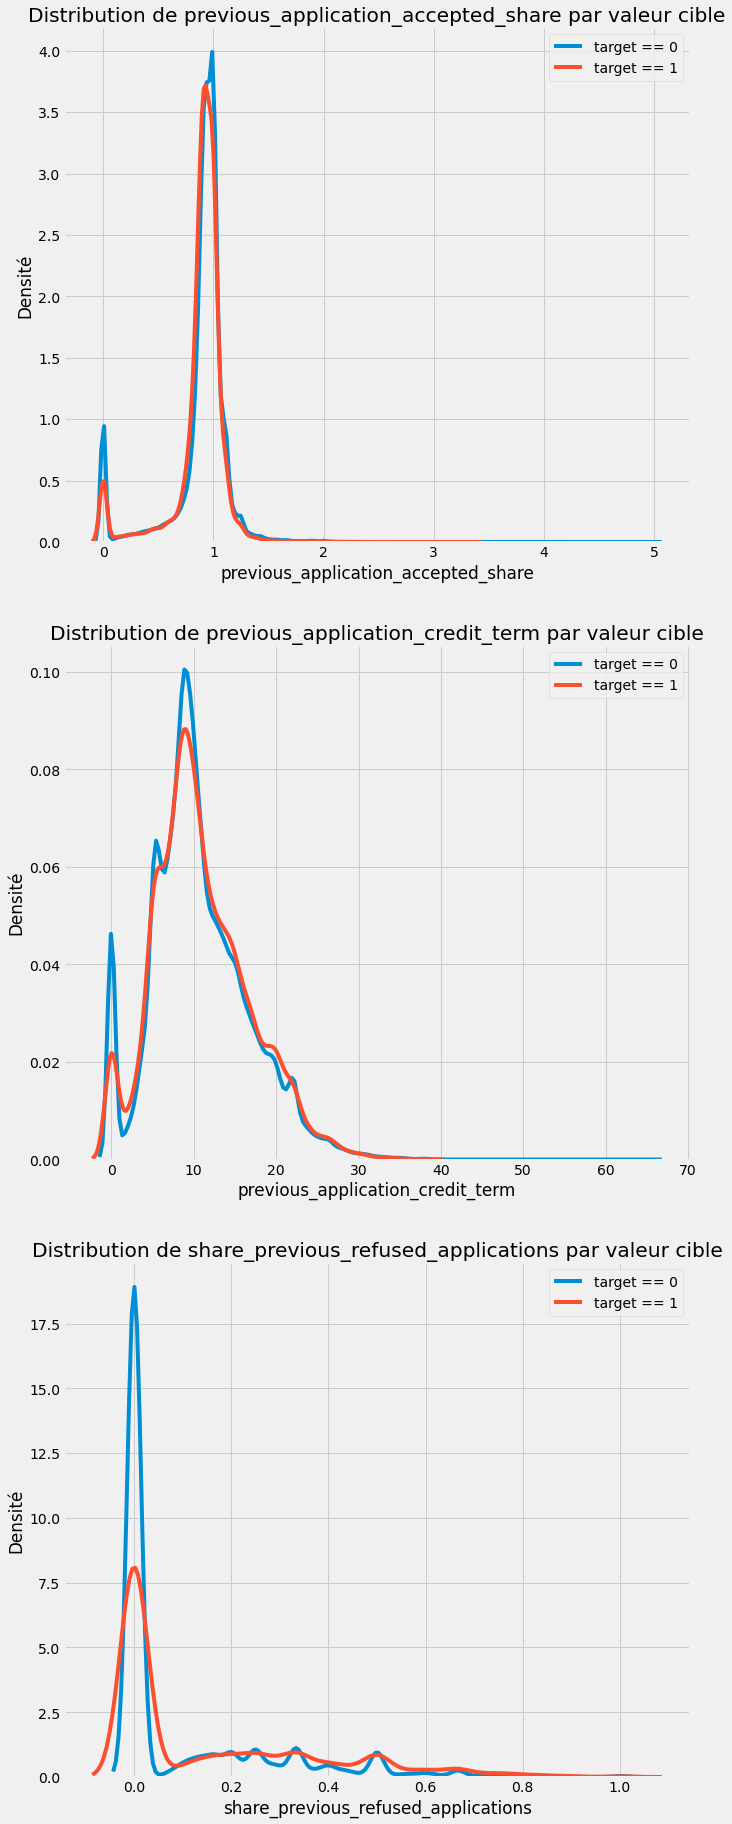

In [191]:
drawing_numerical_plots(data,numerical_created_features,3)

<hr style="border:0.1px solid black"> </hr>

## Sélection de features

In [192]:
data.shape

(356255, 41)

La base de données ainsi formée **contient près de 40 variables**, ce qui reste beaucoup lorsqu'on anticipe les possibles temps de calcul liés à une telle masse de features ; une manière de sélectionner certaines variables (vs d'autres) peut être d'**étudier les corrélations entre nos variables et de conserver une seule variable dans le cas de forte corrélation** (négative comme positive) entre deux variables

In [193]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [194]:
def get_top_correlations(df,n,condition):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = condition)
    return au_corr[0:n]

Etudions d'abord les 10 corrélations **les plus positives**

In [195]:
get_top_correlations(data,10,False)

avg_amount_available_bank_account  withdrawal_limit_bank_account    0.849196
applicant_family_size              children_in_household_rate       0.807722
applicant_total_income             income_share_to_credit           0.713071
avg_amount_available_bank_account  ratio_withdrawn_vs_collected     0.667110
total_credit_amount                years_credit_term                0.656755
withdrawal_limit_bank_account      ratio_withdrawn_vs_collected     0.650058
bureau_seniority_past_loans        bureau_share_active_loans        0.589766
bureau_count_past_loans            bureau_share_active_loans        0.430320
total_credit_amount                annuity_share_to_income          0.372812
bureau_count_past_loans            bureau_seniority_past_loans      0.350211
dtype: float64

On constate **un certain nombre de très fortes corrélations positives, qui paraissent comme étant logiques** : par exemple, on observe une corrélation très forte de près de 85% entre "avg_amount_available_bank_account" et "withdrawal_limit_bank_account" (ce qui est censé, puisque plus on a d'argent sur son compte, plus on a possiblement une limite haute de retrait fixé avec sa banque)

On décide donc de **supprimer les variables les plus corrélées avec les variables qui pourraient davantage nous intéresser** (à chaque fois, sélection de la variable la plus pertinente entre nos paires de variables très fortement corrélées, positivement ou négativement), en se fixant un **seuil aux alentours de 70%**

In [196]:
data = data.drop(columns = ['withdrawal_limit_bank_account',
                           'applicant_family_size',
                           'income_share_to_credit',
                           'ratio_withdrawn_vs_collected',
                           'years_credit_term'])

Regardons à présent les plus fortes corrélations négatives

In [197]:
get_top_correlations(data,10,True)

credit_payment_type            provided_expected_docs_share    -0.772610
applicant_age                  applicant_employed_status       -0.622824
applicant_occupation           applicant_employed_status       -0.550255
level_pop_living_region        internal_rating_living_region   -0.536036
applicant_age                  children_in_household_rate      -0.353765
internal_rating_living_region  source_2                        -0.296475
credit_payment_type            annuity_share_to_income         -0.235511
applicant_housing_type         applicant_age                   -0.232089
credit_payment_type            total_credit_amount             -0.200187
source_3                       bureau_count_past_loans         -0.197059
dtype: float64

In [198]:
data = data.drop(columns = ['provided_expected_docs_share',
                           'applicant_employed_status'])

In [199]:
data.shape

(356255, 34)

Grâce à cette étude, **on a réduit de 7 variables la taille de notre dataset final**, on décide de se séparer également de variables qui ne nous intéressent pas ou qui en tout cas ne sont pas facilement interprétables (comme par exemple les sources extérieures 2 ou 3)

In [200]:
data.columns

Index(['SK_ID_CURR', 'TARGET', 'credit_payment_type', 'applicant_gender',
       'flag_car_owner_applicant', 'applicant_total_income',
       'total_credit_amount', 'applicant_income_type',
       'applicant_best_education', 'applicant_family_status',
       'applicant_housing_type', 'level_pop_living_region',
       'applicant_occupation', 'internal_rating_living_region',
       'weekday_starting_process', 'source_2', 'source_3', 'set',
       'applicant_age', 'annuity_share_to_income',
       'children_in_household_rate', 'bureau_count_past_loans',
       'bureau_count_credit_prolongations', 'bureau_seniority_past_loans',
       'bureau_share_active_loans', 'count_negative_bank_balance',
       'applicant_bank_account_seniority', 'avg_amount_available_bank_account',
       'cumulative_number_of_days_late',
       'previous_difference_paid_installment',
       'previous_difference_months_installment',
       'previous_application_accepted_share',
       'previous_application_credit_te

In [201]:
data = data.drop(columns = ['applicant_income_type',
                            'source_2',
                            'source_3',
                            'count_negative_bank_balance'])

In [202]:
data.shape

(356255, 30)

**Renommons certaines colonnes pour plus de clarté**

In [203]:
data.columns

Index(['SK_ID_CURR', 'TARGET', 'credit_payment_type', 'applicant_gender',
       'flag_car_owner_applicant', 'applicant_total_income',
       'total_credit_amount', 'applicant_best_education',
       'applicant_family_status', 'applicant_housing_type',
       'level_pop_living_region', 'applicant_occupation',
       'internal_rating_living_region', 'weekday_starting_process', 'set',
       'applicant_age', 'annuity_share_to_income',
       'children_in_household_rate', 'bureau_count_past_loans',
       'bureau_count_credit_prolongations', 'bureau_seniority_past_loans',
       'bureau_share_active_loans', 'applicant_bank_account_seniority',
       'avg_amount_available_bank_account', 'cumulative_number_of_days_late',
       'previous_difference_paid_installment',
       'previous_difference_months_installment',
       'previous_application_accepted_share',
       'previous_application_credit_term',
       'share_previous_refused_applications'],
      dtype='object')

In [204]:
data = data.rename(columns = {'SK_ID_CURR': 'applicant_loan_id', 
                              'TARGET': 'target',
                              'set': 'type_of_set'})

In [205]:
data.columns

Index(['applicant_loan_id', 'target', 'credit_payment_type',
       'applicant_gender', 'flag_car_owner_applicant',
       'applicant_total_income', 'total_credit_amount',
       'applicant_best_education', 'applicant_family_status',
       'applicant_housing_type', 'level_pop_living_region',
       'applicant_occupation', 'internal_rating_living_region',
       'weekday_starting_process', 'type_of_set', 'applicant_age',
       'annuity_share_to_income', 'children_in_household_rate',
       'bureau_count_past_loans', 'bureau_count_credit_prolongations',
       'bureau_seniority_past_loans', 'bureau_share_active_loans',
       'applicant_bank_account_seniority', 'avg_amount_available_bank_account',
       'cumulative_number_of_days_late',
       'previous_difference_paid_installment',
       'previous_difference_months_installment',
       'previous_application_accepted_share',
       'previous_application_credit_term',
       'share_previous_refused_applications'],
      dtype='object'

In [206]:
data = data.drop(columns = ['previous_difference_paid_installment','previous_difference_months_installment'])

<hr style="border:0.1px solid black"> </hr>

In [207]:
df_train = data.loc[data['type_of_set'] == 1]
df_train = df_train.drop(columns = ['type_of_set'])
df_train.to_csv('C:\\Users\\pauline_castoriadis\\Documents\\implement_scoring_model\\data\\df_train.csv')

In [208]:
df_test = data.loc[data['type_of_set'] == 0]
df_test = df_test.drop(columns = ['type_of_set','target'])
df_test.to_csv('C:\\Users\\pauline_castoriadis\\Documents\\implement_scoring_model\\data\\df_test.csv')